# find contracts pages in collections of pages

## input data

The input CSV file is generated from content json files that are output of MinerU runs on the original pdf documents. The pdf documents contain several pages, including a few with the contract information we are looking for.

The CSV file contains the columns `docid`, `page`, `block`, `type`, and `content`. `docid` denotes the base filename of the original document, `page` is the page in the original document, `block` is the source block within the page (MinerU does layout reading, therefore partitioning a page in several 'blocks'). `type` can be either of 'text', 'table', or 'discarded': 'discarded' meaning that the block was decided by MinerU to not belong to the variable text on the page, but being part of e.g. constant headers and footers. Finally `content`, contains the text within the box, stripped of leading, trailing, and multiple spaces (one space left).

In [1]:
import pandas as pd

In [2]:
dat = pd.read_csv("data.csv", keep_default_na=False)

In [3]:
dat

,docid,page,block,type,content
0,D-2020-00005018,0,1,text,Lantmateriet Fastighetsinskrivning SE76180Norr...
1,D-2020-00005018,0,2,text,Arendenr: D-2020-00005018 \nInskrivningsdatu...
2,D-2020-00005018,0,3,text,Enligt ansokan har foljande inskrivningsatgard...
3,D-2020-00005018,0,4,text,Avtalsservitut Kraftledning D-2020-00005018:1
4,D-2020-00005018,0,5,text,Om rattigheten upphor helt eller delvis ska ra...
...,...,...,...,...,...
1194,D-2022-00018136,15,208,discarded,VATTENFALL
1195,D-2022-00018136,15,209,discarded,2021-08-31
1196,D-2022-00018136,15,210,discarded,KOPIA
1197,D-2022-00018136,15,211,discarded,5730-6326


## define pages containing contract information

Done from visual inspection.

In [4]:
dat.loc[(dat["docid"] == "D-2020-00005018") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00040677") &
        (dat["page"].isin([1, 2])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00047813") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00150874") &
        (dat["page"].isin([0, 1, 2])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00213476") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00314079") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00400144") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00400146") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2020-00545991") &
        (dat["page"].isin([1, 2, 3])), "hit"] = True
dat.loc[(dat["docid"] == "D-2022-00018136") &
        (dat["page"].isin([2, 3, 4])), "hit"] = True

In [5]:
dat.loc[dat.hit != True, "hit"] = False

In [6]:
dat[15:]

,docid,page,block,type,content,hit
15,D-2020-00005018,0,16,discarded,LANTMATERIET -,False
16,D-2020-00005018,0,17,discarded,UNDERRATTELSE Utskriftsdatum Arendenummer 2020...,False
17,D-2020-00005018,0,18,discarded,2200111207,False
18,D-2020-00005018,0,19,discarded,,False
19,D-2020-00005018,0,20,discarded,,False
...,...,...,...,...,...,...
1194,D-2022-00018136,15,208,discarded,VATTENFALL,False
1195,D-2022-00018136,15,209,discarded,2021-08-31,False
1196,D-2022-00018136,15,210,discarded,KOPIA,False
1197,D-2022-00018136,15,211,discarded,5730-6326,False


## aggregate content into one string per page

In [7]:
dat = dat.drop(["block", "type"], axis=1).groupby(["docid", "page"]).agg(
    {"content": lambda x: "".join(str(x)),
     "hit": lambda x: sum(x) > 0
    }
)

In [8]:
dat

content    hit
docid           page                                                          
D-2020-00005018 0     0     Lantmateriet Fastighetsinskrivning SE761...  False
                1     20    Markupplatelseavtal avseende elektrisk s...   True
                2     37    Markabel a inomvgmre fensidvg forgs p sd...   True
                3     65              Leninvelinaie skyldigheteridet...   True
                4          87    \n88    \nName: content, dtype: object  False
...                                                                 ...    ...
D-2022-00018136 11    1149                                          ...  False
                12    1158    FASTIGHET /SAMFALLIGHET SaMt PROJEKTIN...  False
                13    1165    Fastighetsagare (personnr/org.nr) Agd ...  False
                14    1174                                          ...  False
                15    1178                                Markagare:...  False

[85 rows x 2 columns]

## training and classification

In [9]:
X = dat.iloc[:, 0].values
y = dat.iloc[:, 1].values

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(analyzer="char", ngram_range=(5, 5),
                     strip_accents="unicode", max_features=4500)
X = td.fit_transform(X).toarray()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [13]:
y_pred = classifier.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(y_test, y_pred)

In [15]:
accuracy_score(y_test, y_pred)

1.0

In [16]:
print(classification_report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         8

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



## classical cross validation

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier, X, y)

array([1., 1., 1., 1., 1.])

## leave-one-out cross validation

In [18]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(classifier, X, y, cv=loo)
print(f"Number of cv iterations: {len(scores)}")
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations: 85
Mean accuracy: 1.00


## finding top n-grams

In [19]:
feature_names = td.get_feature_names_out()

In [20]:
feature_names

array(['\nname', ' $\\ s', ' $\\$ ', ..., 'yrels', 'ystem', 'yttja'],
      shape=(4500,), dtype=object)

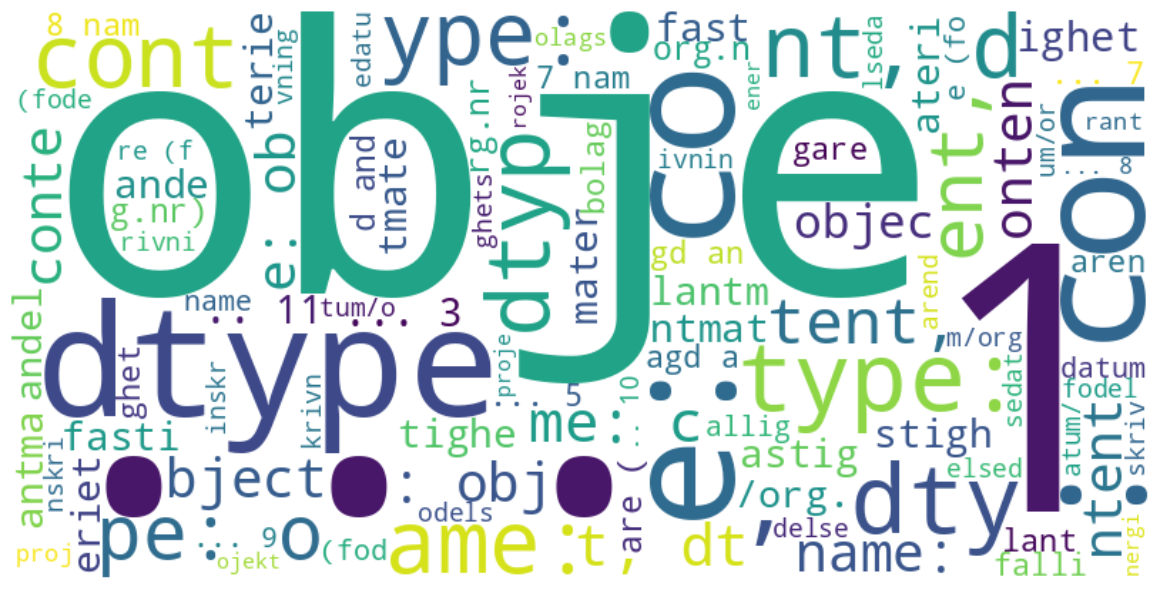

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top n-grams with their scores
docs = X[y == False]
mean_tfidf = docs.mean(axis=0)
n = 100

top_indices = mean_tfidf.argsort()[-n:][::-1]
top_ngrams = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

# Clean n-grams by removing/replacing newlines and other problematic characters
ngram_freq = {}
for ngram, score in zip(top_ngrams, top_scores):
    # Replace newlines and other whitespace with spaces
    cleaned_ngram = ' '.join(ngram.split())
    ngram_freq[cleaned_ngram] = score

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      collocations=False).generate_from_frequencies(ngram_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

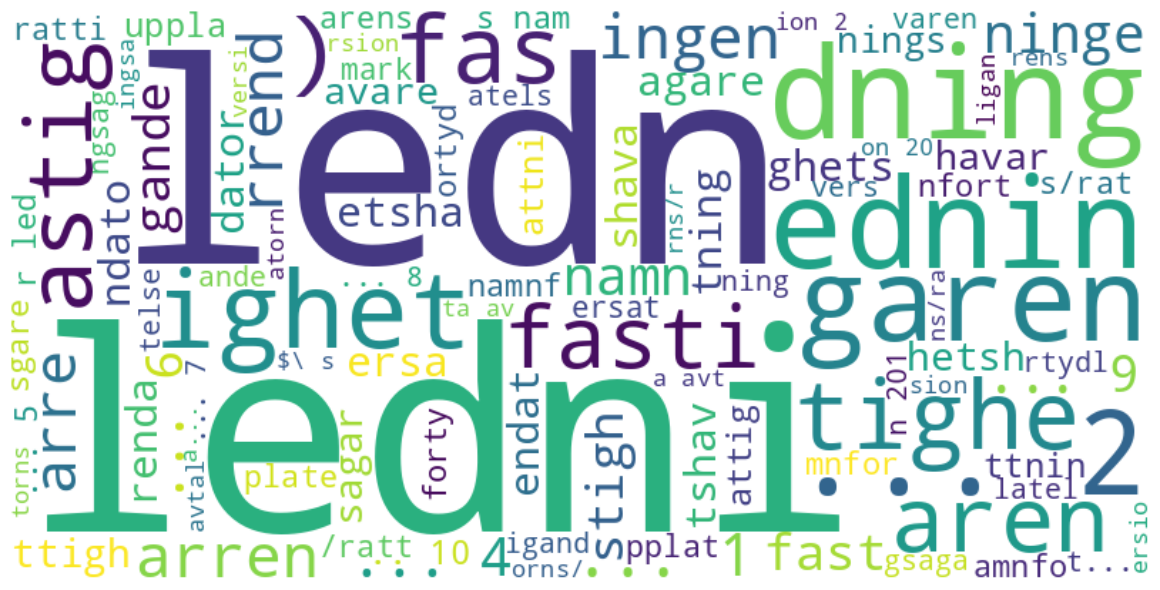

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top n-grams with their scores
docs = X[y == True]
mean_tfidf = docs.mean(axis=0)
n = 100

top_indices = mean_tfidf.argsort()[-n:][::-1]
top_ngrams = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

# Clean n-grams by removing/replacing newlines and other problematic characters
ngram_freq = {}
for ngram, score in zip(top_ngrams, top_scores):
    # Replace newlines and other whitespace with spaces
    cleaned_ngram = ' '.join(ngram.split())
    ngram_freq[cleaned_ngram] = score

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      collocations=False).generate_from_frequencies(ngram_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()